# Data Processing with BERT

Bert Model Download: https://github.com/google-research/bert#pre-trained-models

inspired by: https://github.com/llSourcell/bert-as-service

DOC: https://bert-as-service.readthedocs.io/en/latest/section/get-start.html#start-the-bert-service

Install BERT:
pip install bert-serving-server
pip install bert-serving-client
Python 3.5 and Tensorflow 1.10 required

Download pretrained model:

https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

add unziped to /tmp/uncased_L-12_H-768_A-12/

then start the service by : bert-serving-start -model_dir /tmp/uncased_L-12_H-768_A-12/ -num_worker=1

In [14]:
from bert_serving.client import BertClient
import pandas as pd
import numpy as np
import h5py
from nltk import tokenize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

In [13]:
news = pd.read_csv('../data/mixed_news/news_dataset.csv')
news = news.dropna(subset=['title','content'])
news = news[news.content != ' ']
news = news[news.title != ' ']
news.shape

(27879, 5)

# Vergleichsanalyse:

## Klassifizierung anhand eines Splits:

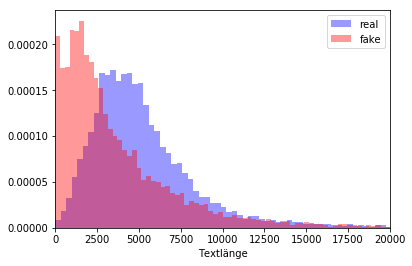

In [11]:
text_len_real  =  [len(c) for c in news[news['label']=='real'].content]
plt.hist(text_len_real,color="b", bins=500,density=True,alpha=0.4,label="real")
text_len_fake = [len(c) for c in news[news['label']=='fake'].content]
plt.hist(text_len_fake,color="r",bins=500, density=True,alpha=0.4,label="fake")
plt.xlim(0,20000)
plt.xlabel("Textlänge")
plt.legend()
plt.show()

In [ ]:
data = pd.DataFrame({"x": text_len_fake+text_len_real, "truth": [0]*len(text_len_fake) + [1]*len(text_len_real)})
split=2500
plt.vlines(split,0,0.00025)
plt.hist(text_len_real,color="b", bins=500,density=True,alpha=0.4,label="real")
plt.hist(text_len_fake,color="r",bins=500, density=True,alpha=0.4,label="fake")
plt.xlim(0,20000)
plt.xlabel("Textlänge")
plt.legend()
plt.show()

In [ ]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
data["predict"] = data.x > split
data.head()
from sklearn.metrics import confusion_matrix
data = data.replace(0,"fake").replace(1,"real").replace(False,"fake").replace(True,"real")
plot_confusion_matrix(data.truth,data.predict,["fake","truth"])

# Using BERT for Datapreprocessing
## Encode Titles:

In [ ]:
bc = BertClient()

In [ ]:
title_enc = bc.encode(list(news['title']))

In [ ]:
with h5py.File('encoded_data/encode_news.h5', 'w') as hf:
    hf.create_dataset("title_encode",  title_enc)

## Encode Text:

In [ ]:
'''
content = []
num_sentences_train = []
for c in news_train['content']:
    tok = tokenize.sent_tokenize(c)
    content  = content + tok
    num_sentences_train.append(len(tok))

train_content_encode = bc.encode(content)
'''

In [ ]:
'''with h5py.File('encode_news.h5', 'a') as hf:
    hf.create_dataset("train_content_encode",  data = train_content_encode)
    hf.create_dataset("train_num_sentences", data = np.array(num_sentences_train))'''

In [ ]:
'''content = []
num_sentences_test = []
for c in news_test['content']:
    tok = tokenize.sent_tokenize(c)
    content  = content + tok
    num_sentences_test.append(len(tok))

test_content_encode = bc.encode(content)'''

In [ ]:
'''with h5py.File('encode_news.h5', 'a') as hf:
    hf.create_dataset("test_content_encode",  data = test_content_encode)
    hf.create_dataset("test_num_sentences", data = np.array(num_sentences_test))'''

## Read encoded data:

In [3]:
with h5py.File('encoded_data/title_encode.h5', 'r') as hf:
    title_encode = hf['title_encode'][:]

preparing for NN:

In [4]:
title_NN = pd.DataFrame(data = title_encode)
X_train, X_test, y_train, y_test = train_test_split(title_NN,news.label, test_size=0.33, stratify=news.label,
                                                                  random_state=42)

# Verkleinerung des Designspace mithilfe einer PCA:

In [ ]:
modell = PCA()
modell.fit(X_train)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(768),np.cumsum(modell.explained_variance_ratio_))
plt.xlabel("Hauptkomponente")
plt.ylabel("Kummulierte Varianz")
plt.show()

Es gibt drei Methoden, um zu entscheiden wie viele Hauptkomponenten ausreichend sind:

1. Methode: eine bestimmter prozentsatz der Varainz soll erklärt sein:

In [ ]:
print("Anzahl der Hauptkomponenten für erklärte Varianz größer 0.8: ", sum(np.cumsum(modell.explained_variance_ratio_)<0.8)+1)

2. Methode: Die Hauptkomponenten, die mehr als die mittlere Varianz erkären

In [ ]:
print("Anzahl der Hauptkomponenten größer der mittleren erklärten Varainz: ",sum(modell.explained_variance_ratio_ > np.mean(modell.explained_variance_ratio_)))

Nutzen des Scree-Plots

In [ ]:
plt.plot(range(768),modell.explained_variance_ratio_)
plt.xlabel("Hauptkomponente")
plt.ylabel("erklärte Varianz")
plt.xlim(0,200)
plt.show()

Der Scree-Plot legt nahe $50-75$ Hauptkomponenten zu nutzen. Ab dann flacht der Graph sehr stark ab

In [ ]:
X_train_red = modell.transform(X_train)[:,:130]
X_test_red = modell.transform(X_test)[:,:130]

In [5]:
LE = LabelEncoder()
LE.fit(["fake","real"])
y_train_enc = LE.transform(y_train)
y_test_enc = LE.transform(y_test)

Es werden die ersten 130 Hauptkomponenten weiterverwendet

In [ ]:
X_train_red = pd.DataFrame(X_train_red)
X_train_red["label"] = y_train_enc
X_test_red = pd.DataFrame(X_test_red)
X_test_red["label"] = y_test_enc

X_test_red.to_hdf('../data/BERT/Bert_title_NN.h5', key='train', mode='w')
X_test_red.to_hdf('../data/BERT/Bert_title_NN.h5', key='test', mode='a')
X_test_red = X_test_red.drop('label',axis=1)
X_train_red = X_train_red.drop('label',axis=1)

Ohne PCA:

In [6]:
X_train = pd.DataFrame(X_train)
X_train["label"] = y_train_enc
X_test = pd.DataFrame(X_test)
X_test["label"] = y_test_enc

X_train.to_hdf('../data/BERT/Bert_title_NN.h5', key='train', mode='w')
X_test.to_hdf('../data/BERT/Bert_title_NN.h5', key='test', mode='a')
X_test = X_test.drop('label',axis=1)
X_train = X_train.drop('label',axis=1)

/home/larsmoellerherm/.local/anaconda3/lib/python3.7/site-packages/pandas/io/pytables.py:274: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)


## NN training

Im weiteren Verlauf werden die Daten ohne Hauptkomponentenanalyse verwendet

In [7]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.savefig("../build/plots/history_bert_title_knn.pdf")
    plt.clf()

seed = 42
rate=0.3
dim = X_train.shape[1]

LR = LeakyReLU()
LR.__name__ = 'relu'

model = Sequential()
model.add(Dense(units=dim*2, activation="relu", input_dim=dim))
model.add(Dropout(rate=0.418,seed=seed))
model.add(Dense(units=76, activation='linear'))
model.add(Dropout(rate=0.5,seed=seed))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.33,seed=seed))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

filepath = '../model/best_bert_title_nn.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train_enc, validation_split=0.3,
                    epochs=300,batch_size=64, callbacks=[checkpoint, TensorBoard(log_dir='../build/graph',
                                                                                histogram_freq=0, write_graph=True)])
print(history.history.keys())
plot_history(history)
plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1536)              1181184   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 76)                116812    
_________________________________________________________________
dropout_2 (Dropout)          (None, 76)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               39424     
_________________________________________________________________
dropout_3 (Dropout)  

KeyboardInterrupt: 

Für den validation und trainings loss History muss beachtet werden, dass wir Dropout layers haben. Die Evaluation des Trainings-Fehlers wird nach jeder batch der Validierungs-Fehler jedoch erst nach jeder Epoche berechnet.


In [51]:
best_model = load_model('../model/best_bert_title_nn.hdf5')
y_pred = best_model.predict(X_test, batch_size=64, verbose=1)
y_pred_train = best_model.predict(X_train,batch_size=64,verbose=1)
y_pred_bool = np.round(y_pred)
print(classification_report(y_test_enc, y_pred_bool))

18678/18678 [==============================] - 2s 117us/step
              precision    recall  f1-score   support

           0       0.77      0.67      0.72      4016
           1       0.77      0.85      0.81      5185

   micro avg       0.77      0.77      0.77      9201
   macro avg       0.77      0.76      0.76      9201
weighted avg       0.77      0.77      0.77      9201



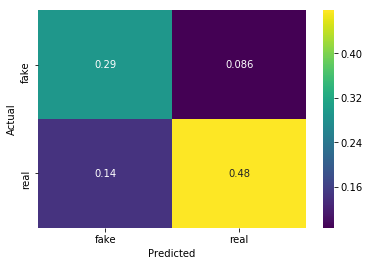

In [50]:
confusion_matrix = pd.crosstab( y_test_enc, y_pred_bool[:,0], rownames=['Actual'], colnames=['Predicted'])

confusion_matrix.columns = ['fake','real']
confusion_matrix = confusion_matrix.rename_axis("Predicted", axis="columns")
confusion_matrix.rename(index = {0.0: "fake", 1.0:'real'}, inplace = True) 
confusion_matrix = confusion_matrix/y_test_enc.shape[0]
sn.heatmap(confusion_matrix, annot=True , cmap='viridis')
plt.show()
plt.savefig("../build/plots/Bert/cnfsn_mtx_bert_title_nn.pdf")
plt.close()

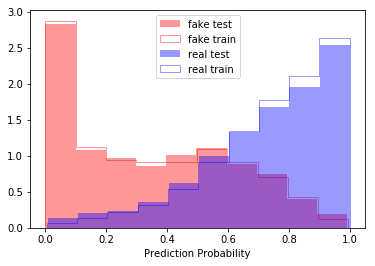

In [56]:
plt.hist(y_pred[y_test_enc == 0],label="fake test", alpha = 0.4, color = "r",density=True)
plt.hist(y_pred_train[y_train_enc == 0],label='fake train', alpha = 0.4, color = 'r', histtype='step',density=True)
plt.hist(y_pred[y_test_enc == 1],label = "real test",alpha = 0.4, color = "b",density=True)
plt.hist(y_pred_train[y_train_enc == 1],label='real train', alpha = 0.4, color = 'b', histtype='step',density=True)

plt.xlabel("Prediction Probability")
plt.legend()
plt.show()
#plt.savefig("../build/plots/Bert/prob_bert_title_nn.pdf")
plt.close()

### ROC Curve:

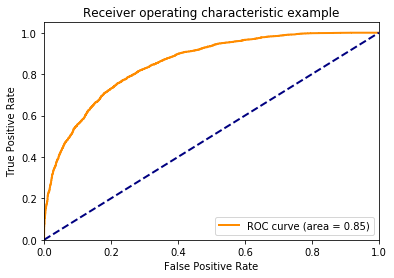

In [10]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test_enc, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
plt.savefig("../build/plots/Bert/roc_bert_title_nn.pdf")
plt.close()